In [ ]:
!pip install torch torchmetrics pytorch_lightning matplotlib seaborn catboost xgboost statsmodels
!pip install -U scikit-learn

In [15]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sn
import numpy as np

import catboost as cat
import xgboost as xgb

from collections import Counter


from scipy.fft import fft, fftfreq
from pandas.plotting import autocorrelation_plot
from statsmodels.tsa.seasonal import seasonal_decompose, STL

from sklearn.metrics import confusion_matrix

from sklearn.cluster import OPTICS
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import mutual_info_regression, mutual_info_classif
from sklearn.feature_selection import SelectKBest, f_regression, f_classif, RFE, SelectFromModel
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error, silhouette_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

In [16]:
import math
from time import time
from tqdm.auto import tqdm

import numpy as np
import pandas as pd
pd.options.display.float_format = '{:,.3f}'.format
from IPython.display import display

# Sklearn & stats tools
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.metrics import mean_absolute_error as mae
from sklearn.metrics import mean_squared_error as mse

# Neural Networks
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torchmetrics

import pytorch_lightning as pl
from pytorch_lightning import Trainer, seed_everything
from pytorch_lightning.loggers.csv_logs import CSVLogger
# from pytorch_lightning.callbacks import EarlyStopping, LearningRateMonitor
from pytorch_lightning.callbacks.early_stopping import EarlyStopping


# Plotting
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib as mpl
plt.style.use('bmh')
mpl.rcParams['figure.figsize'] = 18, 8


if torch.cuda.is_available():
    gpus = 1
else:
    gpus = 0

/Users/miquelsaula/PycharmProjects/ProjectVGM/.conda/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
def calculate_metrics(y_true, y_pred):
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, average=None)
    recall = recall_score(y_true, y_pred, average=None)
    f1 = f1_score(y_true, y_pred, average=None)
    return accuracy, precision, recall, f1

def calculate_proportions(array):
    counts = Counter(array)
    total = array.shape[0]
    proportions = {key: val / total for key, val in counts.items()}
    return proportions

def classification_report(predictions, targets, class_names):
    # Calculate the metrics
    accuracy, precision, recall, f1 = calculate_metrics(targets, predictions)

    # Calculate proportions
    pred_proportions = calculate_proportions(predictions)
    target_proportions = calculate_proportions(targets)

    # Map class indices to class names
    index_to_class_name = {index: class_name for index, class_name in enumerate(class_names)}

    # Print the results
    print(f"Accuracy: {accuracy * 100:.2f}%")

    data = []
    for class_index, class_name in index_to_class_name.items():
        row = {
            'Class': class_name,
            'Precision': precision[class_index] * 100,
            'Recall': recall[class_index] * 100,
            'F1-score': f1[class_index] * 100,
            'Prediction Proportion': pred_proportions.get(class_index, 0) * 100,
            'Target Proportion': target_proportions.get(class_index, 0) * 100,
        }
        data.append(row)

    return pd.DataFrame(data)

# Importación del dataset final

In [4]:
df = pd.read_csv('./final_dataset.csv').drop(columns=['Unnamed: 0'])
df['t'] = pd.to_datetime(df['t'])
df = df.set_index(['t', 'symbol'])
df = df.sort_index()
df.head()

,,o,h,l,c,v,n,vw,diff,emaS,emaM,...,time_embed_month_sin,time_embed_month_cos,time_embed_year_sin,time_embed_year_cos,market_correlation,market_long_term_trend,market_short_term_trend,market_change,alpha,beta
t,symbol,,,,,,,,,,,,,,,,,,,,,
2018-01-02 09:00:00,BABA,173.46,173.90,173.03,173.77,12094,92,173.478710,1.004939,1.000886,1.000067,...,0.000000,1.000000,0.000000,1.000000,NaN,NaN,NaN,NaN,NaN,NaN
2018-01-02 10:00:00,BABA,173.90,174.00,173.83,174.00,7456,28,173.896286,1.002407,1.001139,1.000127,...,0.008727,0.999962,0.000717,1.000000,1.000000,1.000046,1.000046,NaN,NaN,NaN
2018-01-02 11:00:00,BABA,174.15,174.70,174.02,174.58,9966,93,174.341312,1.002559,1.001376,1.000190,...,0.017452,0.999848,0.001435,0.999999,0.895350,1.000505,1.000540,0.697924,NaN,NaN
2018-01-02 12:00:00,BABA,174.50,174.98,174.25,174.72,65516,405,174.598031,1.001473,1.001392,1.000223,...,0.026177,0.999657,0.002152,0.999998,0.933935,1.000610,1.000648,0.417496,NaN,NaN
2018-01-02 13:00:00,BABA,174.68,175.33,174.40,175.00,105976,696,174.928519,1.001893,1.001475,1.000265,...,0.034899,0.999391,0.002869,0.999996,0.963070,1.000622,1.000650,0.082915,NaN,NaN


Magnitud media de la variación de TSLA a través del tiempo

<AxesSubplot:xlabel='t,symbol'>

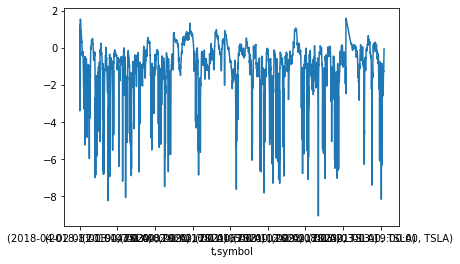

In [5]:
np.log(df.groupby('symbol').get_group('TSLA').ewm(span=500).mean().abs()['pc12']).plot()

/var/folders/4z/l7kc3ncn7g3628qd59lkh1km0000gn/T/ipykernel_41472/894472347.py:6: FutureWarning: Dropping of nuisance columns in rolling operations is deprecated; in a future version this will raise TypeError. Select only valid columns before calling the operation. Dropped columns were Index(['symbol'], dtype='object')
  data = np.log(df.groupby('symbol').get_group('TSLA').reset_index().set_index('t').ewm(span=500).mean().abs()['pc12'])


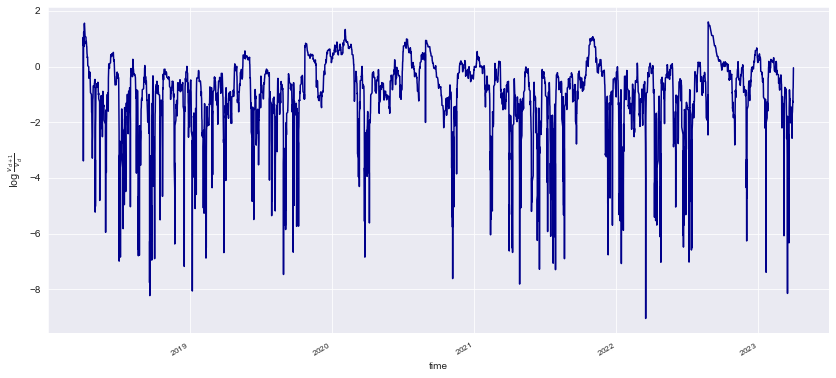

In [6]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.rc('text', usetex=False)
sns.set_style('darkgrid')
data = np.log(df.groupby('symbol').get_group('TSLA').reset_index().set_index('t').ewm(span=500).mean().abs()['pc12'])
plt.figure(figsize=(14, 6)) # Increase the figure size to 10x6 inches
plt.xticks(rotation=30, ha='right', fontsize=8)
plt.xlabel('time')

plt.rc('text', usetex=True)
plt.ylabel(r'$\log{\frac{v_{d+1}}{v_d}}$')
sns.lineplot(data=data, color='darkblue') # Set the line colour to dark blue
plt.rc('text', usetex=False)

<AxesSubplot:>

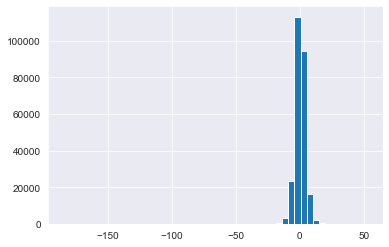

In [7]:
df['pc12'].hist(bins=50)

Top 20 valores PC12

In [8]:
df.reset_index()
df = df.sort_values('pc12')
df['pc12'].head(20)

t                    symbol
2020-08-28 16:00:00  AAPL     -184.750071
2020-08-28 23:00:00  AAPL     -184.596963
2020-08-28 19:00:00  AAPL     -184.265316
2020-08-28 15:00:00  AAPL     -184.231121
2020-08-28 18:00:00  AAPL     -184.055697
2020-08-28 17:00:00  AAPL     -183.823395
2020-08-28 22:00:00  AAPL     -183.693278
2020-08-28 14:00:00  AAPL     -183.454955
2020-08-28 20:00:00  AAPL     -183.117767
2020-08-28 21:00:00  AAPL     -183.108576
2020-08-28 13:00:00  AAPL     -182.843224
2020-08-28 12:00:00  AAPL     -182.328986
2022-07-15 23:00:00  GOOG     -167.303292
2022-07-15 21:00:00  GOOG     -166.804772
2022-07-15 20:00:00  GOOG     -166.225505
2022-07-15 19:00:00  GOOG     -165.731233
2022-07-15 18:00:00  GOOG     -165.239768
2022-07-15 17:00:00  GOOG     -164.780019
2022-07-15 15:00:00  GOOG     -164.267377
2022-07-15 16:00:00  GOOG     -164.259897
Name: pc12, dtype: float64

Bottom 5 valores PC12

In [9]:
df['pc12'].tail()

t                    symbol
2023-02-01 10:00:00  META      51.484519
2023-02-01 20:00:00  META      52.084823
2023-02-01 12:00:00  META      52.233970
2023-02-01 13:00:00  META      52.360424
2023-02-01 19:00:00  META      52.801748
Name: pc12, dtype: float64

## Metodo de categorización 1
Este es el malo, calcula los percentiles generales y agrupa cada instancia en su respectivo grupo

In [10]:
df.sort_values('pc12')
top_value = df['pc12'].quantile(0.95)
bottom_value = df['pc12'].quantile(0.05)

df['category'] = 'middle'
df.loc[df['pc12'] > top_value, 'category'] = 'top'
df.loc[df['pc12'] < bottom_value, 'category'] = 'bottom'

## Metodo 2
Este es el bueno, calcula unos thresholds dinamicos en función de la aproximación de la función de distribución gaussiana para detectar el top 5% y bottom 5% de las instancias de manera contextual. És decir, que en función del contexto del activo en cada momento estima cuales són los valores más extremos que pueden suceder.

In [11]:
from scipy.stats import norm
df = df.sort_index()

# Define the threshold percentile
threshold_percentile = 4
rolling_window = 77

# Compute the rolling mean and standard deviation for each symbol
df['rolling_mean'] = df.groupby('symbol')['pc12'].transform(lambda x: x.rolling(window=rolling_window).mean())
df['rolling_std'] = df.groupby('symbol')['pc12'].transform(lambda x: x.rolling(window=rolling_window).std())

# Compute the upper and lower threshold values for each symbol
df['upper_threshold'] = df['rolling_mean'] + df['rolling_std'] * norm.ppf(1 - threshold_percentile / 100)
df['lower_threshold'] = df['rolling_mean'] - df['rolling_std'] * norm.ppf(1 - threshold_percentile / 100)

# Assign the category based on the thresholds
df['category'] = 'middle'
df.loc[df['pc12'] > df['upper_threshold'], 'category'] = 'top'
df.loc[df['pc12'] < df['lower_threshold'], 'category'] = 'bottom'

df['category'] = df['category'].astype('category')

# Drop the intermediate columns
df.drop(['rolling_mean', 'rolling_std', 'upper_threshold', 'lower_threshold'], axis=1, inplace=True)

Porcentages finales de cada clase:

In [12]:
year = 2022
res = df[df.index.get_level_values('t').year == year].value_counts('category') * 100 / len(df[df.index.get_level_values('t').year == year])

res['middle']

87.58971776006908

In [13]:
amounts = {
    'top': [],
    'middle': [],
    'bottom': [],
}
for year in [2018, 2019, 2020, 2021, 2022, 2023]:
    res = df[df.index.get_level_values('t').year == year].value_counts('category') * 100 / len(df[df.index.get_level_values('t').year == year])
    amounts['top'].append(res['top'])
    amounts['middle'].append(res['middle'])
    amounts['bottom'].append(res['bottom'])

res = df.value_counts('category')

print(f"Mean of 'top' values by year:    {np.mean(amounts['top']):.3f}%")
print(f"Std of 'top' values by year:     {np.std(amounts['top']):.3f}%")

print(f"\nMean of 'middle' values by year: {np.mean(amounts['middle']):.3f}%")
print(f"Std of 'middle' values by year:  {np.std(amounts['middle']):.3f}%")

print(f"\nMean of 'bottom' values by year: {np.mean(amounts['bottom']):.3f}%")
print(f"Std of 'bottom' values by year:  {np.std(amounts['bottom']):.3f}%")

Mean of 'top' values by year:    5.769%
Std of 'top' values by year:     0.231%

Mean of 'middle' values by year: 88.214%
Std of 'middle' values by year:  0.547%

Mean of 'bottom' values by year: 6.017%
Std of 'bottom' values by year:  0.416%


In [14]:
df.columns

Index(['o', 'h', 'l', 'c', 'v', 'n', 'vw', 'diff', 'emaS', 'emaM', 'emaL',
       'std', 'pc', 'pc12', 'mvS', 'mvL', 'mnS', 'mnL', 'rsi', 'rsid', 'rlmS',
       'rlmL', 'rlmD', 'obv', 'obvmS', 'obvmL', 'obvsL', 'obvSH', 'lavgv',
       'lavm', 'lavs', 'avgv', 'ewm_12', 'ewm_26', 'macd', 'signal',
       'macd_std', 'macds', 'financial_data_age', 'P/E', 'P/S', 'P/B',
       'EPS_Growth', 'ROE', 'ROA', 'Gross_Margin', 'Operating_Margin',
       'Net_Profit_Margin', 'Current_Ratio', 'Debt_to_Equity', 'FCF',
       'spy_value', 'time_embed_day_sin', 'time_embed_day_cos',
       'time_embed_week_sin', 'time_embed_week_cos', 'time_embed_month_sin',
       'time_embed_month_cos', 'time_embed_year_sin', 'time_embed_year_cos',
       'market_correlation', 'market_long_term_trend',
       'market_short_term_trend', 'market_change', 'alpha', 'beta',
       'category'],
      dtype='object')

---

# Preparación del dataset

Primero se calcula el punto en el que dividir el dataset a partir de un threshold temporal que divida en un 80/20 el rango general de timestamps del dataset

In [15]:
# Codigo para detectar altas variaciones
df['hv_cat'] = 0
df['hv_cat'].loc[(df['category'] == 'bottom') | (df['category'] == 'top')] = 1

/var/folders/4z/l7kc3ncn7g3628qd59lkh1km0000gn/T/ipykernel_41472/3322020656.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['hv_cat'].loc[(df['category'] == 'bottom') | (df['category'] == 'top')] = 1


In [16]:
df['category'].value_counts()

middle    223834
bottom     15606
top        14825
Name: category, dtype: int64

In [17]:
df['hv_cat'].value_counts()

0    223834
1     30431
Name: hv_cat, dtype: int64

In [18]:
df.index.get_level_values('t').min()
df.index.get_level_values('t').max()

timestamps = df.index.get_level_values('t')
min_timestamp = timestamps.min()
max_timestamp = timestamps.max()

# Find the timestamp that is 80% of the way between the min and max
threshold_timestamp_val = min_timestamp + 0.6 * (max_timestamp - min_timestamp)
threshold_timestamp_test = min_timestamp + 0.85 * (max_timestamp - min_timestamp)
print("60% division timestamp:", threshold_timestamp_val)
print("85% division timestamp:", threshold_timestamp_test)

60% division timestamp: 2021-02-24 03:00:00
85% division timestamp: 2022-06-17 18:30:00


Aquí se puede hacer una primera selección de atributos aunque de momento no se haga nada :)

In [19]:
"""
columns = [
    'pc', 'emaL', 'emaS', 'mvS', 'rsi', 'macds', 'lavs', 'Net_Profit_Margin', 'market_correlation',
    'Gross_Margin', 'P/E', 'time_embed_year_sin', 'time_embed_year_cos', 'financial_data_age', 'obvmL'
]
"""
columns = df.columns

Aqui se divide ya el dataset separando los dataframes directamente en vez de hacerlo con el classico train/test split de toda la vida. Esto es así ya que se desea preprocesar el data_train por separado.

In [20]:
data = df[columns].dropna()
data_train = data[data.index.get_level_values('t') <= threshold_timestamp_val]
data_val = data[(data.index.get_level_values('t') > threshold_timestamp_val) & (data.index.get_level_values('t') <= threshold_timestamp_test)]
data_test = data[data.index.get_level_values('t') > threshold_timestamp_test]

In [23]:
X_train_raw = data_train[columns].drop(columns=['pc12', 'category', 'hv_cat'])
y_train = data_train['category']

X_val_raw = data_val[columns].drop(columns=['pc12', 'category', 'hv_cat'])
y_val = data_val['category']

X_test_raw = data_test[columns].drop(columns=['pc12', 'category', 'hv_cat'])
y_test = data_test['category']

labels_scaler = StandardScaler()
X_train = pd.DataFrame(labels_scaler.fit_transform(X_train_raw), columns=X_train_raw.columns)
X_val = pd.DataFrame(labels_scaler.transform(X_val_raw), columns=X_train_raw.columns)
X_test = pd.DataFrame(labels_scaler.transform(X_test_raw), columns=X_train_raw.columns)

print("Train:")
print(X_train.shape)
print(y_train.shape)
print("\nValidation:")
print(X_val.shape)
print(y_val.shape)
print("\nTest:")
print(X_test.shape)
print(y_test.shape)

Train:
(115029, 65)
(115029,)

Validation:
(61074, 65)
(61074,)

Test:
(37369, 65)
(37369,)
